# 경제 분석 및 예측과 데이터 지능 실습4: Dynamic Factor Model and GARCH

OECD데이터를 활용해 VAR 분석을 실습합니다. Statsmodels을 주로 다루고, 실제 데이터에 적용해 봅니다.

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
# 1. Load & preprocess data
# --------------------------
df = pd.read_csv('../datasets/querterly_oecd_account_data.csv',
                 parse_dates=['date'])
df['date'] = df['date'].dt.to_period('Q')

vars_to_use = ['Y', 'C', 'G', 'I', 'EX', 'IM']

### 분기별 변화율을 계산하고 연도별 변화율로 annualize 합니다.

pct_change : $\frac{x_t - x_{t-1}}{x_{t-1}}$

In [ ]:
# compute annualized q-to-q growth by country
df_growth = (
    df.set_index(['date','country'])[vars_to_use]
      .sort_index()
      .groupby('country')
      .pct_change()   # quarter-to-quarter % change
      .mul(400)       # annualize
      .dropna()
      .reset_index()
)

In [ ]:
# pivot to a wide panel (MultiIndex columns)
panel = df_growth.pivot(
    index='date',
    columns='country',
    values=vars_to_use
)

# fill any gaps (forward/backward) rather than drop
panel = panel.interpolate().ffill().bfill()

# drop any series that ended up constant
panel = panel.loc[:, panel.std() > 0]

# NOW flatten the MultiIndex into single strings: "Y_CAN", "C_DEU", etc.
panel.columns = [f"{var}_{ctry}" for var, ctry in panel.columns]

# standardize (mean=0, std=1)
endog = (panel - panel.mean()) / panel.std()

In [ ]:
# 2. Specify & fit DynamicFactorMQ
# ---------------------------------
k_factors  = 3   # number of common factors
factor_ord = 4   # VAR order for factor dynamics

model = sm.tsa.DynamicFactorMQ(
    endog,
    factors=k_factors,
    factor_orders=factor_ord,
    idiosyncratic_ar1=True,
    standardize=False
)

In [16]:
results = model.fit(disp=False)
print(results.summary())

                               Dynamic Factor Results                              
Dep. Variable:        "Y_CAN", and 65 more   No. Observations:                  139
Model:                Dynamic Factor Model   Log Likelihood               -8477.334
                   + 3 factors in 3 blocks   AIC                          17644.668
                     + AR(1) idiosyncratic   BIC                          18657.061
Date:                     Fri, 16 May 2025   HQIC                         18056.077
Time:                             16:45:26   EM Iterations                      122
Sample:                         06-30-1990                                         
                              - 12-31-2024                                         
Covariance Type:              Not computed                                         
                                Observation equation:                                
Factor loadings:          0          1          2    idiosyncratic: AR(1) 

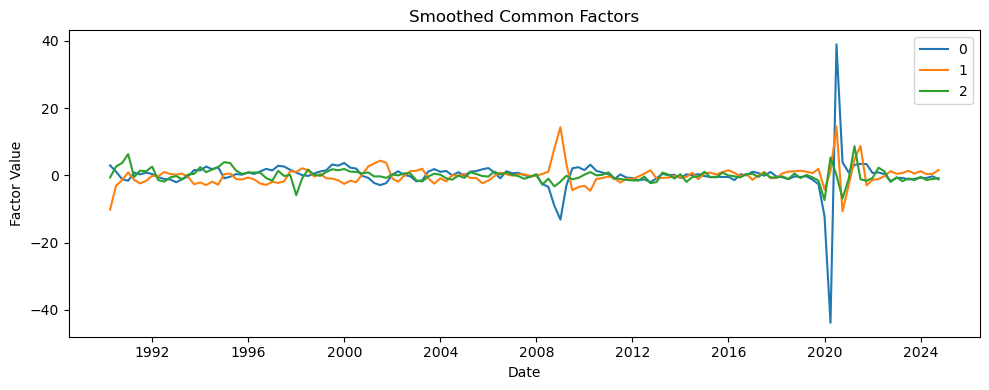

In [32]:
# 3. Extract & plot smoothed factors
# -----------------------------------
factors = results.factors.smoothed
plt.figure(figsize=(10, 4))
for col in factors.columns:
    plt.plot(factors.index.to_timestamp(), factors[col], label=col)
plt.title("Smoothed Common Factors")
plt.xlabel("Date")
plt.ylabel("Factor Value")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# 4. Forecasting
# --------------
fc_res  = results.get_forecast(steps=8)
fc_mean = fc_res.predicted_mean
fc_ci   = fc_res.conf_int()

# rename "lower Y_CAN" → "Y_CAN_lower" etc.
fc_ci.columns = [
    f"{name.split(' ',1)[1]}_{name.split(' ',1)[0]}"
    for name in fc_ci.columns
]

In [22]:
endog.columns

Index(['Y_CAN', 'Y_DEU', 'Y_FRA', 'Y_GBR', 'Y_IND', 'Y_IRL', 'Y_ITA', 'Y_JPN',
       'Y_KOR', 'Y_MEX', 'Y_USA', 'C_CAN', 'C_DEU', 'C_FRA', 'C_GBR', 'C_IND',
       'C_IRL', 'C_ITA', 'C_JPN', 'C_KOR', 'C_MEX', 'C_USA', 'G_CAN', 'G_DEU',
       'G_FRA', 'G_GBR', 'G_IND', 'G_IRL', 'G_ITA', 'G_JPN', 'G_KOR', 'G_MEX',
       'G_USA', 'I_CAN', 'I_DEU', 'I_FRA', 'I_GBR', 'I_IND', 'I_IRL', 'I_ITA',
       'I_JPN', 'I_KOR', 'I_MEX', 'I_USA', 'EX_CAN', 'EX_DEU', 'EX_FRA',
       'EX_GBR', 'EX_IND', 'EX_IRL', 'EX_ITA', 'EX_JPN', 'EX_KOR', 'EX_MEX',
       'EX_USA', 'IM_CAN', 'IM_DEU', 'IM_FRA', 'IM_GBR', 'IM_IND', 'IM_IRL',
       'IM_ITA', 'IM_JPN', 'IM_KOR', 'IM_MEX', 'IM_USA'],
      dtype='object')

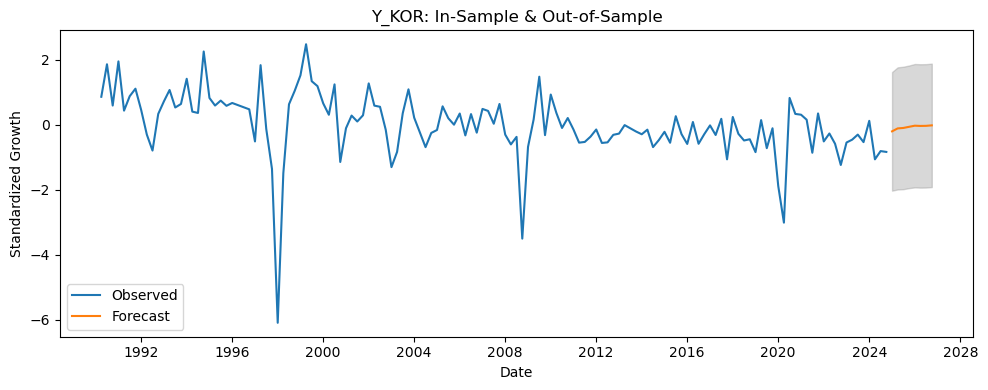

In [23]:
series = "Y_KOR"
plt.figure(figsize=(10,4))
plt.plot(endog.index.to_timestamp(), endog[series], label="Observed")
plt.plot(fc_mean.index.to_timestamp(), fc_mean[series], label="Forecast")
plt.fill_between(
    fc_ci.index.to_timestamp(),
    fc_ci[f"{series}_lower"],
    fc_ci[f"{series}_upper"],
    color='gray', alpha=0.3
)
plt.title(f"{series}: In-Sample & Out-of-Sample")
plt.xlabel("Date")
plt.ylabel("Standardized Growth")
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# 5. Diagnostics
# --------------
# Ljung–Box p-values per series
lb_pvals = {
    col: sm.stats.acorr_ljungbox(results.resid[col], lags=[10], return_df=True)
               ['lb_pvalue'].iloc[0]
    for col in results.resid.columns
}
lb_df = pd.DataFrame.from_dict(
    lb_pvals, orient='index',
    columns=['Ljung-Box p-value (lag=10)']
)
print("\nLjung-Box test:\n", lb_df)


Ljung-Box test:
         Ljung-Box p-value (lag=10)
Y_CAN                     0.949511
Y_DEU                     0.662279
Y_FRA                     0.898482
Y_GBR                     0.591868
Y_IND                     0.001418
...                            ...
IM_ITA                    0.004023
IM_JPN                    0.227427
IM_KOR                    0.101877
IM_MEX                    0.703488
IM_USA                    0.572683

[66 rows x 1 columns]


In [30]:
results.get_coefficients_of_determination()

,0,1,2
Y_CAN,0.865622,0.001769,0.033460
Y_DEU,0.762435,0.000193,0.032595
Y_FRA,0.915685,0.065917,0.001384
Y_GBR,0.886840,0.035227,0.001229
Y_IND,0.708788,0.035325,0.112756
...,...,...,...
IM_ITA,0.625978,0.015222,0.002079
IM_JPN,0.008524,0.325954,0.043797
IM_KOR,0.075360,0.086540,0.176474
IM_MEX,0.479819,0.103453,0.013823


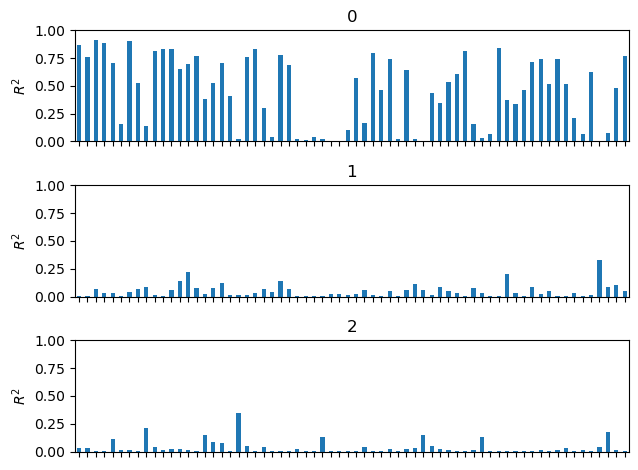

In [31]:
results.plot_coefficients_of_determination()
plt.tight_layout()
plt.show()